# Analysis Muons' Snapshots
In this notebook, we analyse the snapshot created from muons' simulations.
In particular, the snapshots have been created over a time window of `10us` and `Dt=10us` (single integration).

In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [2]:
dirin = os.path.join("..", "..", "Development", "Out", "T10us", "Muons")
filename = "Muons_wtQEff_Snapshots_T10000_DT10000_Grp1_Seed123456789_Part1.csv"
df = pd.read_csv(os.path.join(dirin, filename), comment='#', index_col=False)
df = df[df.columns[:-1]]
df = df[df.pedetected>0]    # discard event 1 that is created empty when grp=1
print("[Info] Loaded {} events wt non-zero detections in 10us".format(len(df)))

[Info] Loaded 14836 events wt non-zero detections in 10us


In [3]:
df.pedetected.describe()

count     14836.000000
mean       3214.474993
std       14852.419500
min           1.000000
25%          21.000000
50%         745.500000
75%        3282.500000
max      865951.000000
Name: pedetected, dtype: float64

Efficiency (cut 4MeV): 0.7125909948773255


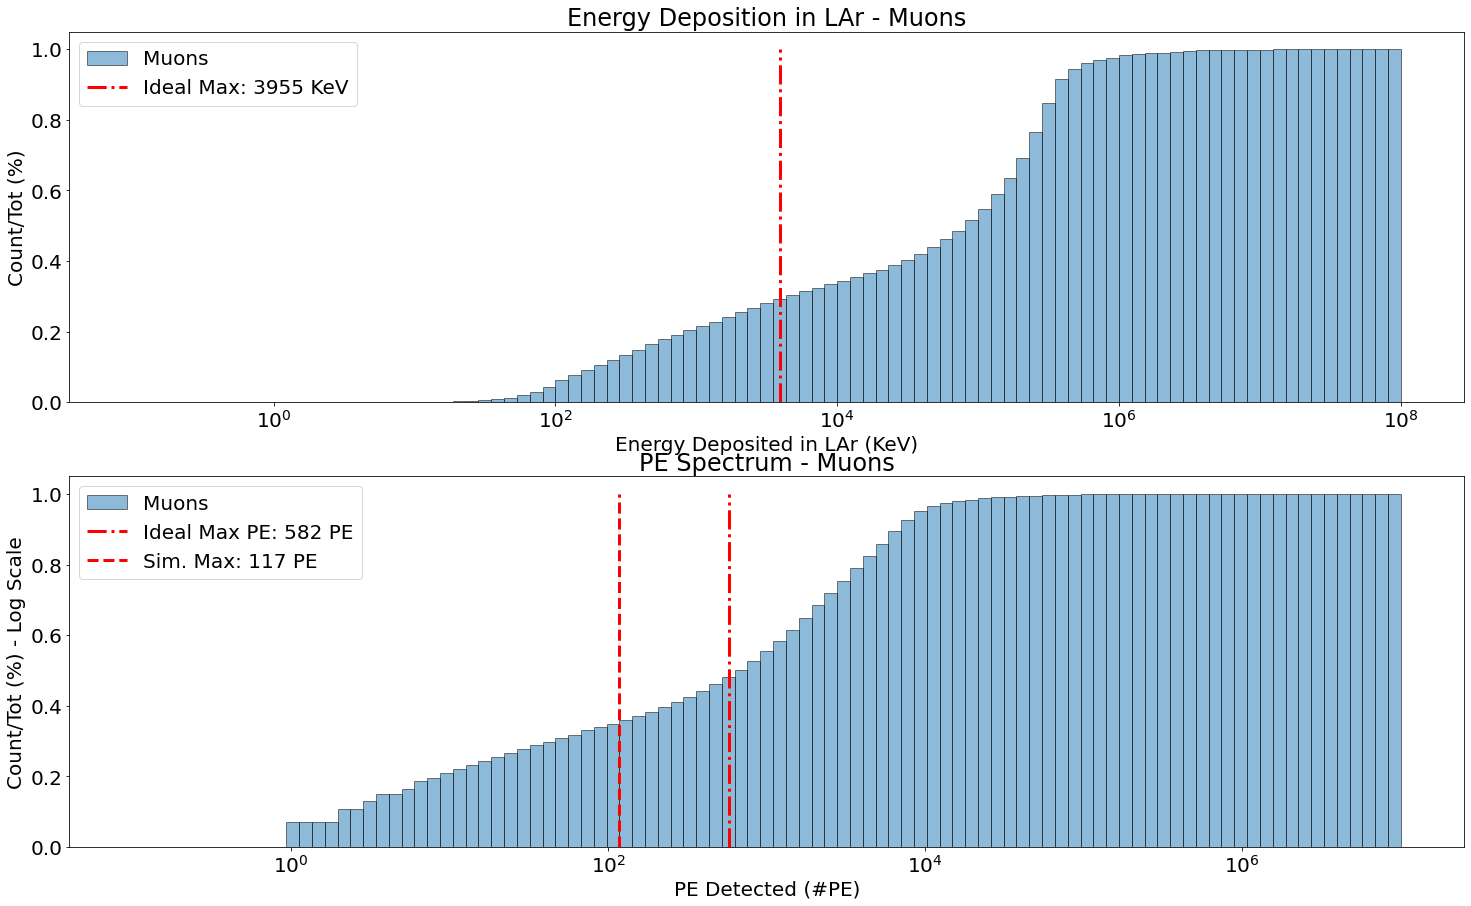

Efficiency (cut 600PE): 0.5248719331356161


In [24]:
alpha=0.5
ar39_max_energy = 565
best_eff = 0.0092
quantum_eff = 0.4
op_yield = 40
ideal_max_edep = 7 * ar39_max_energy
ideal_max_npe = int(7 * ar39_max_energy * op_yield * best_eff * quantum_eff)

plt.subplot(2,1,1)
plt.title("Energy Deposition in LAr - Muons")
bins = np.logspace(-1, 8, 100)
plt.hist(df.energydeposition, bins=bins, label="Muons", density=True, cumulative=True, edgecolor='k', alpha=alpha)
plt.vlines(x=ideal_max_edep, ymin=0, ymax=1, color='r', linestyles='dashdot', linewidth=3, label="Ideal Max: {} KeV".format(ideal_max_edep))
plt.xlabel("Energy Deposited in LAr (KeV)")
plt.ylabel("Count/Tot (%)")
plt.xscale('log')
#plt.yscale('log')
plt.legend()
print("Efficiency (cut 4MeV): {}".format(len(df[df.energydeposition>4000])/len(df)))

plt.subplot(2,1,2)
bins = np.logspace(-1, 7, 100)
plt.hist(df.pedetected, bins=bins, label="Muons", density=True, cumulative=True, edgecolor='k', alpha=alpha)
plt.vlines(x=ideal_max_npe, ymin=0, ymax=1, color='r', linestyles='dashdot', linewidth=3, label="Ideal Max PE: {} PE".format(ideal_max_npe))
plt.vlines(x=117, ymin=0, ymax=1, color='r', linestyles='dashed', linewidth=3, label="Sim. Max: {} PE".format(117))
plt.title("PE Spectrum - Muons")
plt.xlabel("PE Detected (#PE)")
plt.ylabel("Count/Tot (%) - Log Scale")
#plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.show()
print("Efficiency (cut 600PE): {}".format(len(df[df.pedetected>600])/len(df)))


In [31]:
n_muon_events = len(df.index.unique())
ideal_marginals_events = df[df.pedetected < 582].index.unique()
marginals_events = df[df.pedetected <= 117].index.unique()
print("[Info] Ideal Marginal muons: {}/{} => {:.2f} %".format(len(ideal_marginals_events), n_muon_events, len(ideal_marginals_events)/n_muon_events*100))
print("[Info] Simulated Marginal muons: {}/{} => {:.2f} %".format(len(marginals_events), n_muon_events, len(marginals_events)/n_muon_events*100))

[Info] Ideal Marginal muons: 7003/14836 => 47.20 %
[Info] Simulated Marginal muons: 5176/14836 => 34.89 %


In [7]:
def stddev_idslices_fun(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row[i]) for i in range(len(row))] for item in id_list]
    if id_population:    # check if the list of slice ids is not empty
        return np.std(id_population)
    else:
        return -1


In [32]:
marginals_df= df[df.pedetected <= 117]
std_event_marginals = marginals_df.apply(lambda row: stddev_idslices_fun(row[3:]), axis=1)
std_event_all = df.apply(lambda row: stddev_idslices_fun(row[3:]), axis=1)

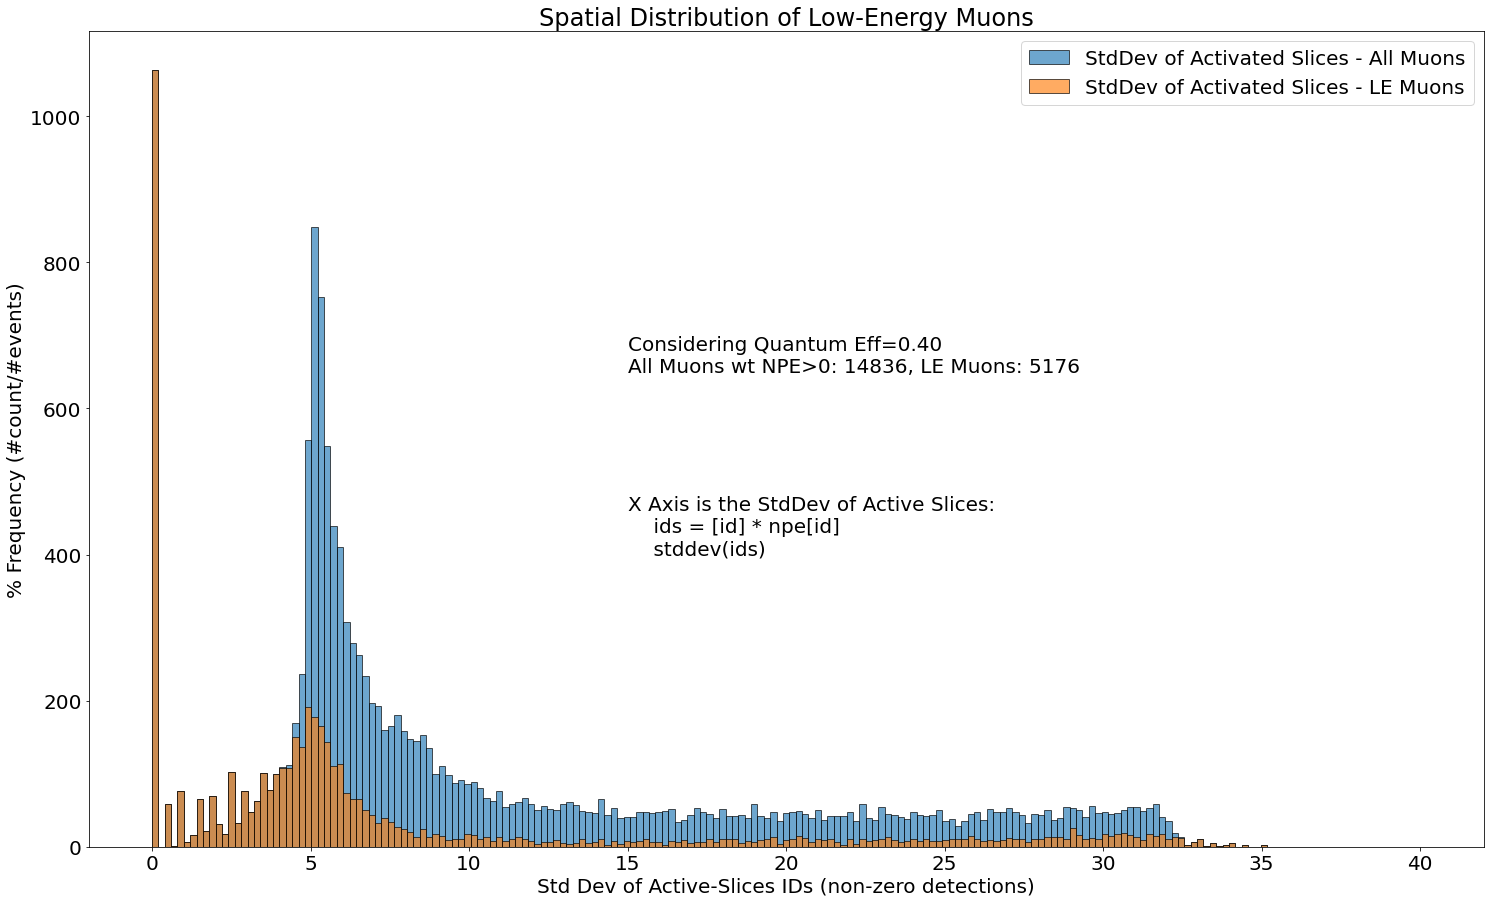

In [33]:
alpha=0.65
bins = np.linspace(0, 40, 200)
plt.title("Spatial Distribution of Low-Energy Muons")
plt.xlabel("Std Dev of Active-Slices IDs (non-zero detections)")
plt.ylabel("% Frequency (#count/#events)")
plt.hist(std_event_all, bins=bins, label="StdDev of Activated Slices - All Muons", density=False, edgecolor='k', alpha=alpha)
plt.hist(std_event_marginals, bins=bins, label="StdDev of Activated Slices - LE Muons", density=False, edgecolor='k', alpha=alpha)
plt.text(15, 650, "Considering Quantum Eff=0.40\n" \
                  "All Muons wt NPE>0: {}, " \
                  "LE Muons: {}".format(len(df), len(marginals_df)))
plt.text(15, 400, "X Axis is the StdDev of Active Slices:\n" \
                  "    ids = [id] * npe[id]\n" \
                  "    stddev(ids)")
plt.legend()
plt.show()

# Compare wt 7 Ar39 pileups

In [2]:
def load_dataframe_from_files(dirin, fileprefix):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {}".format(files[0]))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:]:
        print("[Info] Loading {}".format(file))
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    return df

In [3]:
dirin = os.path.join("..", "..", "Development", "Out", "T10us", "Ar39_1to7Pileups")
prefix_7Ar39_files = "Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part*csv"
df7 = load_dataframe_from_files(dirin, prefix_7Ar39_files)
print("[Info] 7 Ar39: {} events".format(df7.eventnumber.nunique()))

[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part2.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part3.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part4.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part5.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part6.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part7.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp7_Seed123456789_Part8.csv
[Info] Loading ../../Development/Out/T10us/Ar39_1to7Pileups/Ar39_06142020_10

In [12]:
small_df7 = df7.iloc[:100000]
std_event_df7 = small_df7.apply(lambda row: stddev_idslices_fun(row[3:-1]), axis=1)

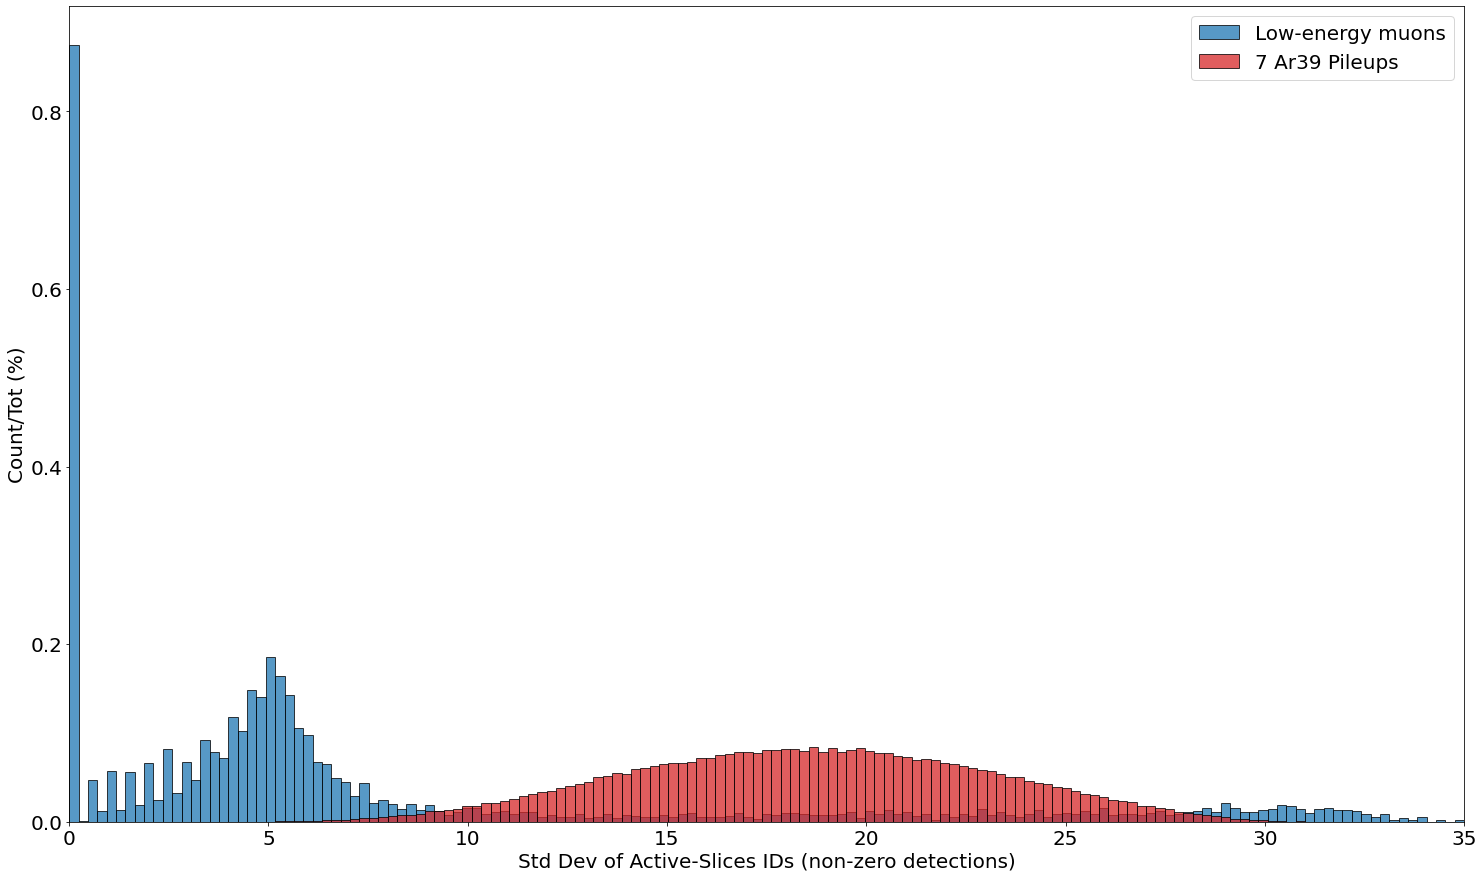

In [34]:
alpha=0.75
bins = np.linspace(0, 35, 150)
#plt.title("Spatial Distribution of Marginal Muons")
plt.xlabel("Std Dev of Active-Slices IDs (non-zero detections)")
plt.ylabel("Count/Tot (%)")
plt.hist(std_event_marginals, bins=bins, label="Low-energy muons", density=True, edgecolor='k', alpha=alpha)
plt.hist(std_event_df7, bins=bins, label="7 Ar39 Pileups", density=True, edgecolor='k', alpha=alpha, color='#d62728')
plt.legend()
plt.xlim(0,std_event_marginals.max())
plt.show()

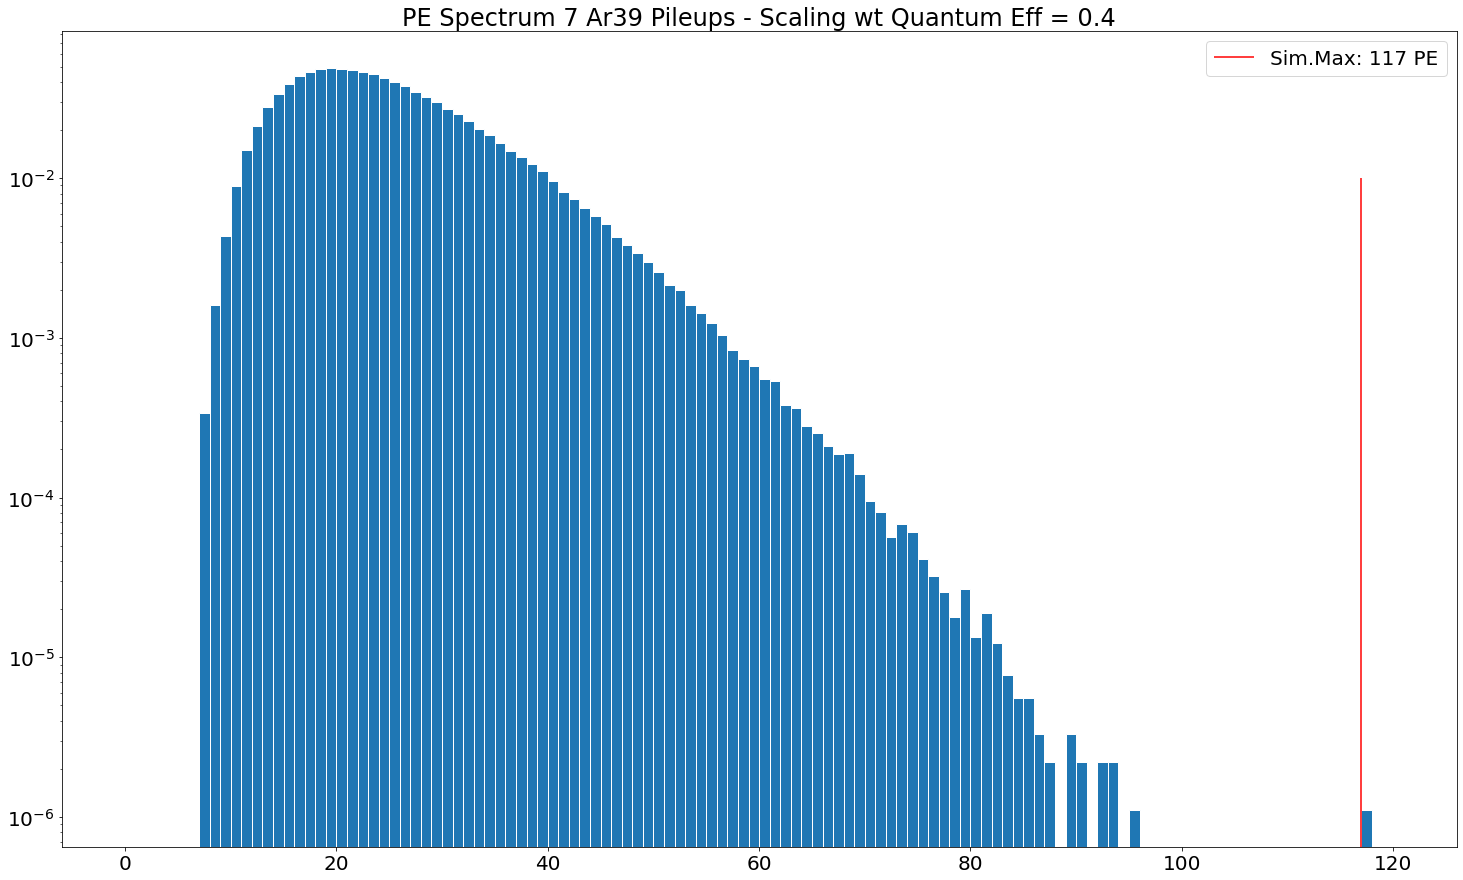

In [29]:
bins = np.linspace(0, 120, 121)
plt.hist(df7.pedetected, bins=bins, density=True, edgecolor='w')
plt.yscale('log')
plt.title("PE Spectrum 7 Ar39 Pileups - Scaling wt Quantum Eff = 0.4")
plt.vlines(df7.pedetected.max(), ymin=0, ymax=0.01, color='r', label="Sim.Max: {} PE".format(df7.pedetected.max()))
plt.legend()
plt.show()